In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

In [2]:
print(tf.__version__)

2.1.0


In [3]:
BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    # 由于Windows路径格式问题，需要修改代码才能正确分配标签：
    # https://github.com/lyhue1991/eat_tensorflow2_in_30_days/issues/19
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [4]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

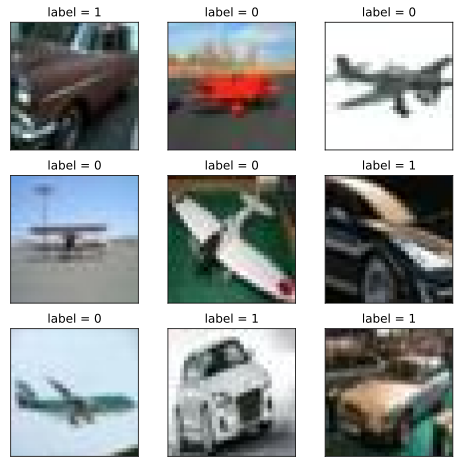

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [7]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


In [8]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [9]:
import datetime
import os

# logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'keras_model', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tf2在windows中存在bug，解决方法是将路径使用os.path.join包装
# 详见：https://www.zhihu.com/question/324633187

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 [==============================] - 27s 266ms/step - loss: 0.4261 - accuracy: 0.7975 - val_loss: 0.3433 - val_accuracy: 0.8440
Epoch 2/10
100/100 [==============================] - 21s 208ms/step - loss: 0.3310 - accuracy: 0.8573 - val_loss: 0.2607 - val_accuracy: 0.8895
Epoch 3/10
100/100 [==============================] - 21s 211ms/step - loss: 0.2613 - accuracy: 0.8889 - val_loss: 0.2172 - val_accuracy: 0.9120
Epoch 4/10
100/100 [==============================] - 23s 232ms/step - loss: 0.2202 - accuracy: 0.9128 - val_loss: 0.1933 - val_accuracy: 0.9255
Epoch 5/10
100/100 [==============================] - 22s 223ms/step - loss: 0.1957 - accuracy: 0.9217 - val_loss: 0.1921 - val_accuracy: 0.9280
Epoch 6/10
100/100 [==============================] - 21s 214ms/step - loss: 0.1664 - accuracy: 0.9330 - val_loss: 0.1663 - val_accuracy: 0.9350
Epoch 7/10
100/100 [==============================] - 21s 210ms/step - loss: 0.1530 - a

In [10]:
logdir

'data\\keras_model\\20200726-234714'

In [11]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./data/keras_model (started 2:42:26 ago; pid 19728)


In [12]:
#在tensorboard中查看模型

# 需要 pip install jupyter-tensorboard
notebook.start("--logdir ./data/keras_model")

Reusing TensorBoard on port 6006 (pid 19728), started 2:42:26 ago. (Use '!kill 19728' to kill it.)

In [13]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.426113,0.7975,0.343276,0.8440
2,0.330966,0.8573,0.260692,0.8895
3,0.261291,0.8889,0.217241,0.9120
4,0.220250,0.9128,0.193340,0.9255
5,0.195676,0.9217,0.192114,0.9280
6,0.166419,0.9330,0.166275,0.9350
7,0.152967,0.9399,0.165708,0.9285
8,0.127687,0.9513,0.160989,0.9335
9,0.116050,0.9556,0.159320,0.9395


In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

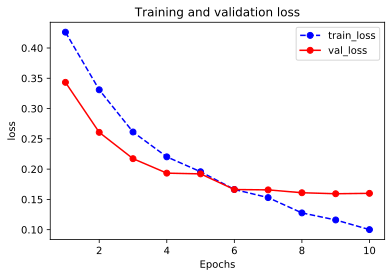

In [15]:
plot_metric(history,"loss")

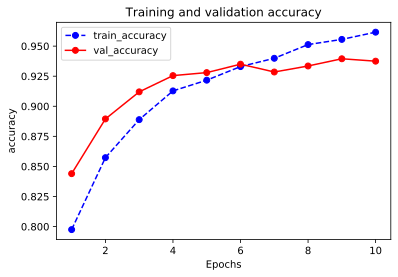

In [16]:
plot_metric(history,"accuracy")

In [17]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 2s 118ms/step - loss: 0.1600 - accuracy: 0.9375
0.15999254249036313 0.9375


In [18]:
model.predict(ds_test)

array([[9.9997842e-01],
       [9.2428923e-01],
       [9.8763520e-01],
       ...,
       [5.0283200e-01],
       [9.9966371e-01],
       [9.7390934e-05]], dtype=float32)

In [19]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

tf.Tensor(
[[5.7426644e-03]
 [5.6986439e-05]
 [9.9991930e-01]
 [5.8649434e-03]
 [9.9627388e-01]
 [1.6427400e-02]
 [4.3829138e-04]
 [9.9988854e-01]
 [3.0845884e-02]
 [9.9963236e-01]
 [9.5056266e-01]
 [6.5943390e-01]
 [3.0106928e-03]
 [9.9834156e-01]
 [7.6121232e-04]
 [9.9973959e-01]
 [9.9301428e-01]
 [8.0127064e-03]
 [3.9466918e-02]
 [9.9979430e-01]], shape=(20, 1), dtype=float32)
